Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


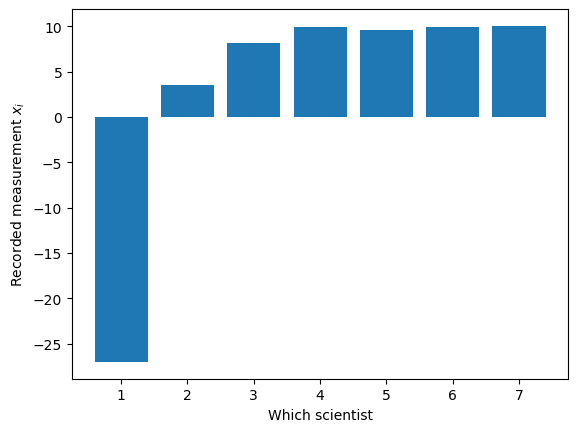

In [5]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/var/folders/w5/8c5jkv6s63969h0v_c6mcr7r0000gn/T/ipykernel_32097/1639954671.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$")
/var/folders/w5/8c5jkv6s63969h0v_c6mcr7r0000gn/T/ipykernel_32097/1639954671.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$p(\sigma)$")


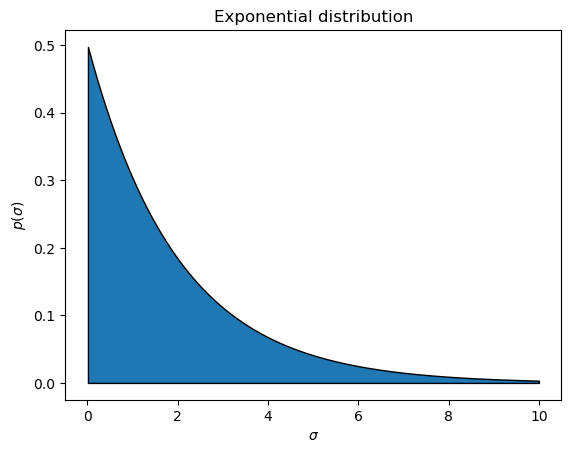

In [7]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
plt.title("Exponential distribution");

# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [9]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, x | alpha, beta), scalar
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!

    """
    assert mu.ndim == 0
    assert sigma.shape == (7,)
    
    # YOUR CODE HERE
    #If any value of the sigmas is negative we return an infinte negative value
    if torch.any(sigma <= 0):
        return float('-inf')
        
    #creating the PDFs in log format to find the log joint of $$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$
    log_prior_mu = dist.Normal(loc=0.0, scale=alpha).log_prob(mu)
    
    #Since sigma has 7 values same with measurements we use the sum function to find the total value in log_prior_sigma and log_likelihood 
    log_prior_sigma = dist.Exponential(rate = beta).log_prob(sigma).sum()
    likelihoods = dist.Normal(loc=mu, scale=sigma).log_prob(measurements)
    log_likelihood = likelihoods.sum()

    #Adding all the priors so we can find the log joint
    log_joint = log_prior_mu + log_prior_sigma + log_likelihood
    
    return log_joint

#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [11]:
# (GRADING)

In [12]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [14]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """
    
    # YOUR CODE HERE
    
    #Defining the standard deviations for mu and sigma
    mu_proposal_std = 0.2
    q_proposal_std = 0.2

    #Defining proposal distributations for both mu and sigma to sample from
    q_mu = dist.Normal(loc = mu, scale = mu_proposal_std)
    q_sigma = dist.Normal(loc = sigma, scale = q_proposal_std)
    
    return q_mu, q_sigma


### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [16]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
del q_mu, q_sigma

In [17]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """
    
    accepted = False

    
    #Defining the proposal distributations for Mu and Sigma
    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)
    
    # YOUR CODE HERE

    #Finding log of the joint probability for old values of mu and sigma
    log_p_old = log_joint(mu, sigma, alpha, beta)

    #Sampling new proposed values for mu and sigma
    mu_dash = q_mu.sample()
    sigma_dash = q_sigma.sample()

    #Finding log of the joint probability for new values of mu and sigma
    log_p_new = log_joint(mu_dash, sigma_dash, alpha, beta)

    #Check if the new values of sigma and mu are accepted
    """if p_new - p_old > torch.rand(1).log().item():
        mu = mu_dash
        sigma = sigma_dash
        accepted = True
    else:
        accepted = False"""
    
    prob_accept = torch.exp(log_p_new - log_p_old)

    if prob_accept > torch.rand(1).item():
        mu = mu_dash
        sigma = sigma_dash
        accepted = True
    else:
        accept = False
    
    
    
    return mu, sigma, accepted

## Running MCMC

We've supplied the outer loop for you -- it will call and execute your `mcmc_step` function. You should *not* need to edit it!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [19]:
def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [20]:
def algo_parameters():
    """ TODO: set these to appropriate values:
    
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """
    
    # YOUR CODE HERE

    #Defining the sample numbers and the burnin percentage
    N_samples = 10000
    N_burnin = int(0.1 * N_samples)
    
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [22]:
mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)
print("acceptance rate:", accepted)

acceptance rate: 0.3082


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/w5/8c5jkv6s63969h0v_c6mcr7r0000gn/T/ipykernel_32097/2920453112.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")
/var/folders/w5/8c5jkv6s63969h0v_c6mcr7r0000gn/T/ipykernel_32097/2920453112.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu$")


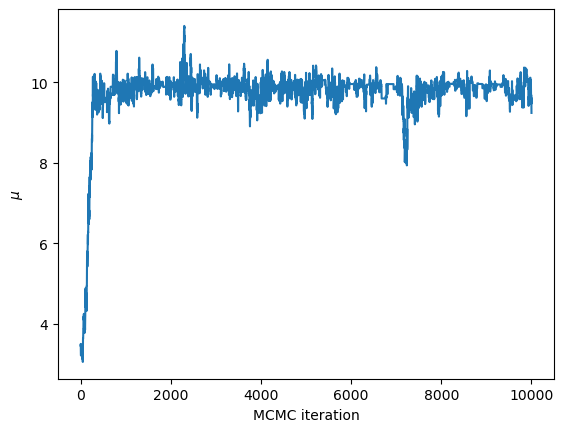

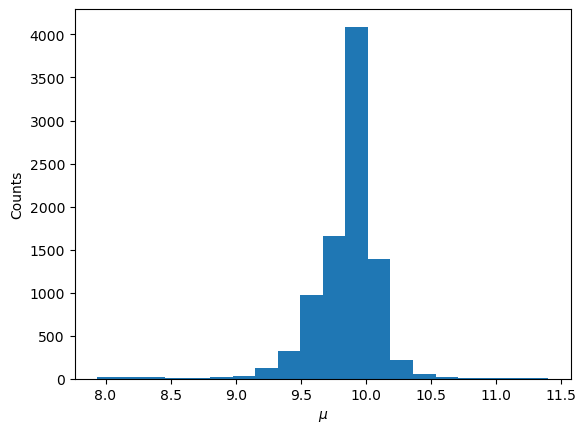

In [23]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\mu$")
plt.ylabel("Counts");

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/var/folders/w5/8c5jkv6s63969h0v_c6mcr7r0000gn/T/ipykernel_32097/1079867295.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$\sigma_i$");


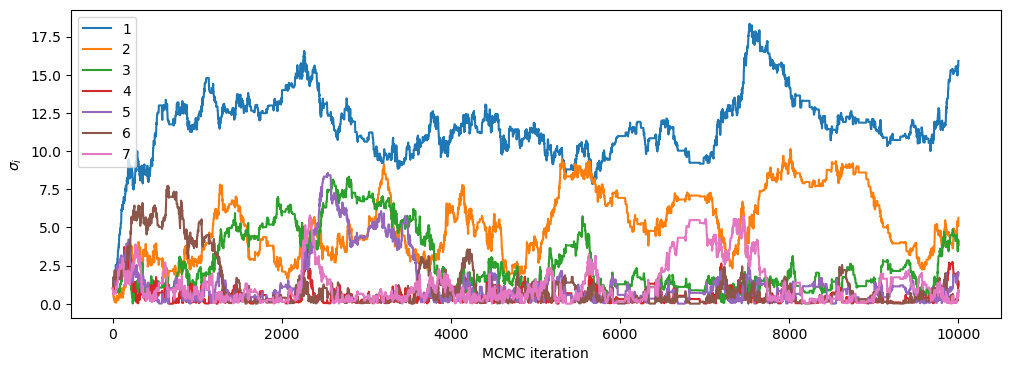

In [24]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\sigma_i$");

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/w5/8c5jkv6s63969h0v_c6mcr7r0000gn/T/ipykernel_32097/2243842497.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Estimated measurement std $\sigma_i$");


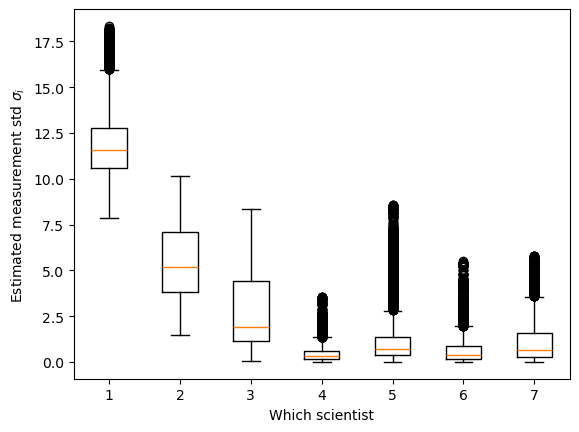

In [25]:
plt.boxplot(sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [27]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """
    
    # YOUR CODE HERE

    #Dropping the burn in values of MUs
    mu_post_burn = mu_chain[N_burnin:]
    
    mu = mu_post_burn.mean()
    
    return mu
    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """
    
    # YOUR CODE HERE
    
    #Dropping the burn in values of MUs
    mu_post_burn = mu_chain[N_burnin:]

    #Finding the mean of mu values which have a value smaller than 9 
    estimate_mu = (mu_post_burn < 9).float().mean()

    return estimate_mu

In [28]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

E[mu] = 9.8548
Pr(mu < 9) = 0.0093


# SHORT ANSWER SECTION (4 points)

Please answer the following 2 questions, for up to two points each:

1. Describe your choices of MCMC proposal distributions. How did you select them? How do you know they are "good"?
2. In your `mcmc_step`, we consider 8 random variables, $\mu, \sigma_1, \dots, \sigma_7$, but you probably implemented this using a single accept-reject step (i.e., you propose new values for all random variables, and then jointly accept all of them, or not). Suppose someone suggested instead proposing for each of these variables one-at-a-time sequentially, including a separate accept-reject step after each. Might this be a good idea, and why or why not?

Question 1:

A normal distribution was chosen as the proposal distribution for $\mu$ due to its symmetry, continuity, and unbounded nature, aligning well with $\mu$’s domain over the real line. Using a normal distribution centred at the current value of $\mu$ facilitates efficient local exploration within the parameter space.

Initially, a small standard deviation of $0.1$ was selected for the proposal distribution of $\mu$. This led to a high acceptance rate, indicating limited parameter space exploration due to conservative proposals. To balance the acceptance rate and effective exploration, the standard deviation was adjusted to $0.2$, resulting in an acceptance rate within the range of $0.2$ to $0.5$. This adjustment allowed the Markov chain to mix more effectively.

Diagnostic plots, including trace plots and histograms, confirmed that the chain was mixing satisfactorily and converging appropriately with this adjusted proposal distribution, indicating an effective choice for $\mu$.

For the $\sigma_i$ parameters, normal distributions were similarly used as proposal distributions. Normal distributions simplify implementation and sampling, with symmetry easing the computation of the Metropolis-Hastings acceptance probability by cancelling out proposal densities in the acceptance ratio.

A potential issue with using normal distributions for the $\sigma_i$ is the possibility of proposing negative values, as standard deviations must be positive. To address this, a check in the log_joint function returns negative infinity if any $\sigma_i \leq 0$, effectively rejecting such proposals and ensuring the Markov chain explores only valid parameter values.

The trace plots and acceptance rates suggest that the proposal distributions for $\mu$ and $\sigma_i$ facilitated convergence and efficient mixing. The acceptance rates achieved an appropriate balance between exploring the parameter space and maintaining reasonable acceptance probabilities, allowing for efficient sampling from the posterior distribution.

Question 2:

Proposing joint updates for all parameters ($\mu$ and $\sigma_1, \dots, \sigma_7$) in a single accept-reject step offers advantages by capturing parameter correlations, potentially leading to improved mixing of the Markov chain. Since $\mu$ and the $\sigma_i$ are correlated and jointly influence the likelihood function, updating them together allows for more effective exploration of the joint posterior distribution, respecting these correlations.

In contrast, proposing updates for each parameter one at a time sequentially, with separate accept-reject steps, simplifies the proposal mechanism and may yield higher acceptance rates for individual parameters due to smaller proposed changes. However, this approach may not improve overall efficiency if the chain mixes slowly, especially when parameters are strongly correlated. Sequential updates may fail to account for correlations between $\mu$ and the $\sigma_i$, resulting in inefficient exploration of the parameter space and potentially requiring more iterations to achieve the same level of precision.

Additionally, updating parameters sequentially increases computational costs because the log_joint function must be evaluated multiple times per iteration—once for each parameter update. In contrast, joint updates require only a single evaluation per iteration. This can significantly increase computational costs, especially in higher-dimensional problems.

While sequential updates can be beneficial for weakly correlated or nearly independent parameters, in this case, where $\mu$ and the $\sigma_i$ are correlated, joint updates are more efficient. Joint updates allow the MCMC algorithm to move through the parameter space more effectively, reducing autocorrelation in the samples and improving the effective sample size.

In summary, proposing joint updates for all parameters is generally more efficient as it accounts for parameter correlations, enhances MCMC efficiency, and reduces computational costs. Sequential updates may lack these advantages, resulting in slower mixing and increased computational demands.

#### Ignore the following cells. They are used by the grading system.

In [32]:
# (GRADING)

In [33]:
# (GRADING)

In [34]:
# (GRADING)

In [35]:
# (GRADING)

In [36]:
# (GRADING)

# EXTRA CREDIT TASK #4 (2 points): Estimate $\alpha$ and $\beta$

Did we choose the hyperparameters $\alpha$ and $\beta$ well? Or were these poor selections?

One way of checking whether $\alpha$ and $\beta$ are set well is by computing a marginal likelihood estimate, i.e. estimating $p(x | \alpha, \beta)$ for different choices of $\alpha, \beta$.

However, a different option is to *also* perform Bayesian inference over $\alpha$ and $\beta$! To do this, we need to do three things:

1. Define a prior $p(\alpha, \beta)$
2. Define MCMC proposals $q(\alpha' | \alpha)$ and $q(\beta' | \beta)$
3. Update the MCMC algorithm itself to also sample $\alpha, \beta$.

To do this, this involves targeting the joint probability distribution

$$p(x,\mu,\sigma,\alpha,\beta) = p(x | \mu, \sigma)p(\mu | \alpha)p(\sigma | \beta)p(\alpha)p(\beta).$$

You can write your MCMC algorithm so that it alternates between doing updates on $\mu, \sigma$ (using your existing `mcmc_step` function) and doing updates on $\alpha, \beta$ (using a new `mcmc_step_hyperparams` function).

To do this you need to implement two things:

1. `log_prior_alpha_beta`: given $\alpha,\beta$, return $\log p(\alpha, \beta)$. You are free to define whatever sort of prior you think is appropriate.
2. `mcmc_step_hyperparams`: do a single MCMC step (including accept / reject) to update $\alpha, \beta$.

These will then be called by the `run_mcmc_bonus` function, below.

In [38]:
def log_prior_alpha_beta(alpha, beta):
    """
    Define a prior distribution on alpha, beta, and return its log probability
    
    INPUT:
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    log_prob : scalar, `log p(alpha, beta)`
    
    """

    # YOUR CODE HERE
    
    k_alpha = 50  # shape parameter
    theta_alpha = 1.0  # scale parameter
    k_beta = 1.5  # shape parameter
    theta_beta = 1.5  # scale parameter
    
    log_prior_alpha = dist.Gamma(k_alpha, 1/theta_alpha).log_prob(alpha)
    log_prior_beta = dist.Gamma(k_beta, 1/theta_beta).log_prob(beta)
    log_p_a_b = log_prior_alpha + log_prior_beta

    return log_p_a_b 


In [39]:
def mcmc_step_hyperparams(mu, sigma, alpha, beta):
    """
    Run an MCMC step on alpha and beta
    
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    alpha    : the next value of alpha in the MCMC chain
    beta     : the next value of beta in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted
    
    """
    # YOUR CODE HERE
    
    accepted = False
    
    alpha_dev = 3.0
    beta_dev = 0.5

    # Step 2: Generate proposal distributions for alpha and beta
    q_a = dist.Normal(alpha, alpha_dev)
    q_b = dist.Normal(beta, beta_dev)

    # Step 3: Sample candidate values (ensure positivity)
    alpha_pro = q_a.sample()  # Ensure positive values
    beta_pro = q_b.sample() # Ensure positive values

    if alpha_pro <= 0 or beta_pro <= 0: 
        return alpha, beta, accepted

    # Step 4: Compute current and proposed log probabilities
    log_p_cur = log_prior_alpha_beta(alpha, beta) + log_joint(mu, sigma, alpha, beta)
    log_p_pro = log_prior_alpha_beta(alpha_pro, beta_pro) + log_joint(mu, sigma, alpha_pro, beta_pro)

    # Accept/reject based on the acceptance probability
    acceptance_probability = torch.exp(log_p_pro - log_p_cur)

    # Step 5: Decide whether to accept the proposed values
    if torch.rand(1).item() < acceptance_probability:
        accepted = True
        return alpha_pro, beta_pro, accepted
    else:
        return alpha, beta, accepted


### Run this MCMC algorithm, and plot the results.

What do you think?

1. Are these results qualitatively different?
2. Were the original choices of $\alpha, \beta$ reasonable?
3. How sensitive are these results to $\alpha, \beta$? To $p(\alpha, \beta)$?

In [41]:
def run_mcmc_bonus(N_iters, mu_init, sigma_init, alpha_init, beta_init):
    """ Run an MCMC algorithm for a fixed number of iterations.
    
    This also runs MCMC on "hyperparameters" alpha and beta.
    
    """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    alpha_chain = [alpha_init]
    beta_chain = [beta_init]
    for _ in range(N_iters):
        alpha, beta, accepted = mcmc_step_hyperparams(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        alpha_chain.append(alpha)
        beta_chain.append(beta)

        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), torch.stack(alpha_chain), torch.stack(beta_chain)

In [42]:
new_mu_chain, new_sigma_chain, alpha_chain, beta_chain = run_mcmc_bonus(N_samples, mu_chain[-1], sigma_chain[-1], torch.tensor(50.0), torch.tensor(0.5))

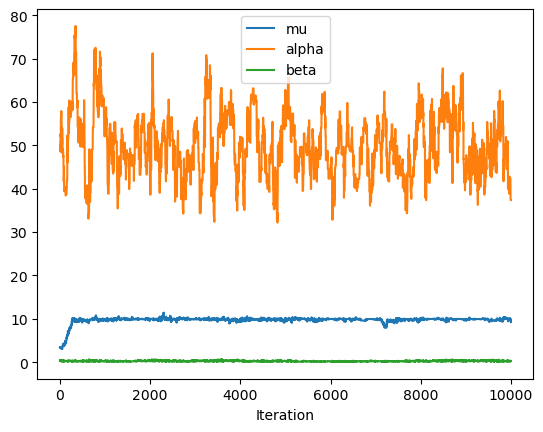

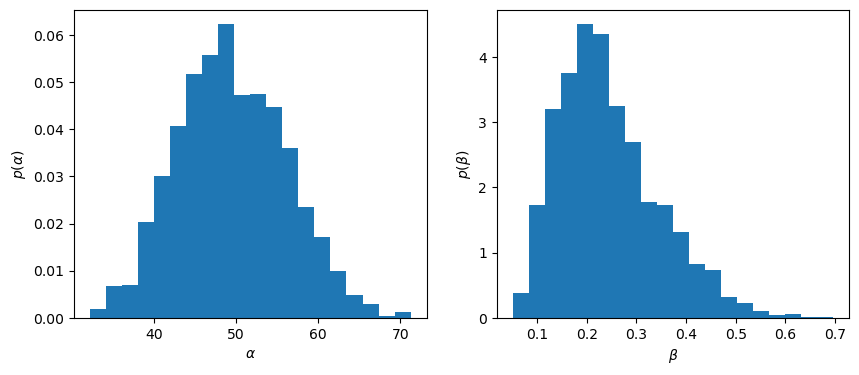

In [43]:
plt.plot(mu_chain)
plt.plot(alpha_chain);
plt.plot(beta_chain);
plt.legend(['mu', 'alpha', 'beta']);
plt.xlabel("Iteration");
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(alpha_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\alpha$")
plt.ylabel("$p(\\alpha)$")
plt.subplot(122)
plt.hist(beta_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\beta$")
plt.ylabel("$p(\\beta)$");

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/w5/8c5jkv6s63969h0v_c6mcr7r0000gn/T/ipykernel_32097/273400075.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu$")
/var/folders/w5/8c5jkv6s63969h0v_c6mcr7r0000gn/T/ipykernel_32097/273400075.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$p(\mu)$");


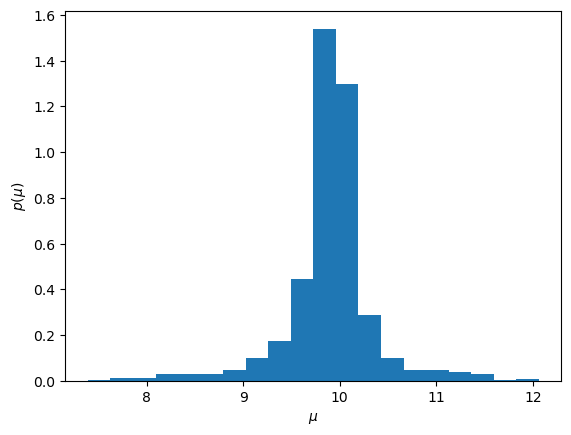

In [44]:
plt.hist(new_mu_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$");

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/w5/8c5jkv6s63969h0v_c6mcr7r0000gn/T/ipykernel_32097/1670354910.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Estimated measurement std $\sigma_i$");


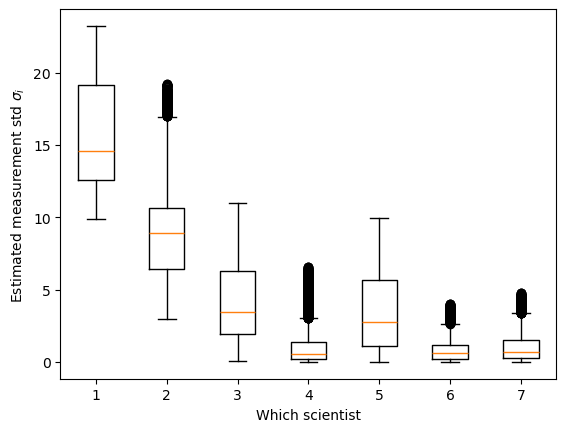

In [45]:
plt.boxplot(new_sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

In [46]:
# (GRADING)

In [47]:
# (GRADING)